In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import os
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import importlib
import model_helper as model

In [2]:
importlib.reload(model)

<module 'model_helper' from '/home/tux/ml_proyecto_final/notebooks/model_helper.py'>

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
data_path = "../data/processed/appendicitis_cleaned_data_v1s.csv"
df = pd.read_csv(data_path)
df.head()

,Age,BMI,Sex,Height,Weight,Diagnosis,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,...,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,US_Performed,US_Number,Free_Fluids,Age_Group,BMI_Category
0,12.68,16.9,female,148.0,37.0,appendicitis,yes,no,yes,yes,...,0.0,no,normal,no,yes,yes,882.0,no,Preteen,Underweight
1,14.10,31.9,male,147.0,69.5,no appendicitis,no,yes,yes,yes,...,3.0,yes,normal,no,yes,yes,883.0,no,Teenager,Obese
2,14.14,23.3,female,163.0,62.0,no appendicitis,no,no,yes,yes,...,3.0,no,constipation,no,yes,yes,884.0,no,Teenager,Normal
3,16.37,20.6,female,165.0,56.0,no appendicitis,no,yes,yes,no,...,0.0,yes,normal,no,yes,yes,886.0,no,Teenager,Normal
4,11.08,16.9,female,163.0,45.0,appendicitis,yes,no,yes,yes,...,0.0,no,constipation,no,yes,yes,887.0,no,Preteen,Underweight


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.shape

(589, 30)

In [7]:
df.isnull().sum().sum()

np.int64(0)

## Before any preprocessing, lets divide the data

In [8]:
X = df.drop(columns=["Diagnosis", "BMI", "Age"], axis=1)
y_raw = df["Diagnosis"]

In [9]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
joblib.dump(le, "../artifacts/label_encoder.joblib")

['../artifacts/label_encoder.joblib']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [11]:
print("Classes (original):", list(le.classes_))
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Classes (original): ['appendicitis', 'no appendicitis']
Train size: (471, 27) Test size: (118, 27)


## Preprocessing pipeline

In [12]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

Numerical features: ['Height', 'Weight', 'Body_Temperature', 'WBC_Count', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP', 'US_Number']
Categorical features: ['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Neutrophilia', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'US_Performed', 'Free_Fluids', 'Age_Group', 'BMI_Category']


In [13]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)



In [14]:
joblib.dump(preprocessor, "../mlflow/artifacts/prepocessor.joblib")

['../mlflow/artifacts/prepocessor.joblib']

In [15]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Preprocessed train shape:", X_train_preprocessed.shape)

Preprocessed train shape: (471, 49)


## Model pipelines

#### Logistic Regression 

In [16]:
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        penalty="l1", solver="saga", max_iter=5000, random_state=RANDOM_STATE
    ))
])

In [17]:
rf_pipeline = Pipeline(steps=[
("preprocessor", preprocessor),
("model", RandomForestClassifier(random_state=RANDOM_STATE))
])

In [18]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        eval_metric="logloss", random_state=RANDOM_STATE
    ))
])

In [19]:
# quick sanity check
for name, pipe in [
    ("Random Forest", rf_pipeline),
    ("Logistic Regression", lr_pipeline)
]:
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print(f"{name} test accuracy: {acc:.3f}")

Random Forest test accuracy: 0.805
Logistic Regression test accuracy: 0.822


In [20]:
joblib.dump(rf_pipeline, "../mlflow/artifacts/rf_pipeline_base.joblib")
joblib.dump(lr_pipeline, "../mlflow/artifacts/lr_pipeline_base.joblib")
joblib.dump(xgb_pipeline, "../mlflow/artifacts/xgb_pipeline_base.joblib")

['../mlflow/artifacts/xgb_pipeline_base.joblib']

### Cross-validation and hyperparameter search

In [21]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [22]:
rf_param_dist = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__bootstrap": [True, False],
    "model__max_features": [None, 'sqrt', 'log2']
}

In [23]:
lr_param_dist = {
    "model__C": uniform(0.01, 10),
    "model__fit_intercept": [True, False]
}

In [24]:
xgb_param_dist = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": randint(3, 20),
    "model__learning_rate": uniform(0.01, 0.3),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__gamma": uniform(0, 0.4)
}

In [25]:
search_config = {
    "cv": cv_strategy,
    "n_iter": 20,
    "scoring": "recall",
    "n_jobs": -1,
    "verbose": 2,
    "random_state": 42
}

In [26]:
rf_search = RandomizedSearchCV(rf_pipeline, rf_param_dist, **search_config)
lr_search = RandomizedSearchCV(lr_pipeline, lr_param_dist, **search_config)
xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_param_dist, **search_config)

In [27]:
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV accuracy:", rf_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__bootstrap=True, model__max_depth=17, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=17, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=17, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=17, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=   0.4s
[CV] END model__bootstrap=True, model__max_depth=17, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=   0.4s
[CV] END model__bootstrap=True, model__max_depth

In [28]:
lr_search.fit(X_train, y_train)
print("Best LR params:", lr_search.best_params_)
print("Best LR CV accuracy:", lr_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=3.7554011884736247, model__fit_intercept=True; total time=   0.3s
[CV] END model__C=1.844347898661638, model__fit_intercept=False; total time=   0.3s
[CV] END model__C=4.468327528535911, model__fit_intercept=True; total time=   0.3s
[CV] END model__C=3.7554011884736247, model__fit_intercept=True; total time=   0.3s
[CV] END model__C=1.844347898661638, model__fit_intercept=False; total time=   0.4s
[CV] END model__C=3.7554011884736247, model__fit_intercept=True; total time=   0.4s
[CV] END model__C=4.468327528535911, model__fit_intercept=True; total time=   0.4s
[CV] END model__C=4.468327528535911, model__fit_intercept=True; total time=   0.4s
[CV] END model__C=1.844347898661638, model__fit_intercept=False; total time=   0.5s
[CV] END model__C=1.844347898661638, model__fit_intercept=False; total time=   0.5s[CV] END model__C=0.5908361216819946, model__fit_intercept=False; total time=   0.2s

[CV] END model__

In [29]:
xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV accuracy:", xgb_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=0.749816047538945, model__gamma=0.3802857225639665, model__learning_rate=0.22959818254342154, model__max_depth=9, model__n_estimators=221, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__colsample_bytree=0.749816047538945, model__gamma=0.3802857225639665, model__learning_rate=0.22959818254342154, model__max_depth=9, model__n_estimators=221, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__colsample_bytree=0.6232334448672797, model__gamma=0.3464704583099741, model__learning_rate=0.19033450352296263, model__max_depth=5, model__n_estimators=249, model__subsample=0.6225646316108401; total time=   0.2s
[CV] END model__colsample_bytree=0.749816047538945, model__gamma=0.3802857225639665, model__learning_rate=0.22959818254342154, model__max_depth=9, model__n_estimators=221, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__colsample_by

In [30]:
for name, search in [
    ("Random Forest", rf_search),
    ("Logistic Regression", lr_search), 
    ("XGBoost", xgb_search)
]:
    y_pred = search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} - Test Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))


Random Forest - Test Accuracy: 0.746
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        67
           1       0.71      0.71      0.71        51

    accuracy                           0.75       118
   macro avg       0.74      0.74      0.74       118
weighted avg       0.75      0.75      0.75       118


Logistic Regression - Test Accuracy: 0.822
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        67
           1       0.83      0.75      0.78        51

    accuracy                           0.82       118
   macro avg       0.82      0.81      0.82       118
weighted avg       0.82      0.82      0.82       118


XGBoost - Test Accuracy: 0.839
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        67
           1       0.83      0.78      0.81        51

    accuracy                           0.84       118
   macro avg  

In [31]:
joblib.dump(rf_search.best_estimator_, "../mlflow/artifacts/rf_best_model.joblib")
joblib.dump(lr_search.best_estimator_, "../mlflow/artifacts/lr_best_model.joblib")
joblib.dump(xgb_search.best_estimator_, "../mlflow/artifacts/xgb_best_model.joblib")

['../mlflow/artifacts/xgb_best_model.joblib']

 ## MLFlow model saving

In [32]:
import mlflow
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
mlflow.set_experiment("Appendicitis_Diagnosis_Models")

<Experiment: artifact_location='file:///home/tux/ml_proyecto_final/notebooks/mlruns/259622151298174711', creation_time=1762915409955, experiment_id='259622151298174711', last_update_time=1762915409955, lifecycle_stage='active', name='Appendicitis_Diagnosis_Models', tags={}>

In [34]:
model.evaluate_and_log_model("RandomForest", rf_search.best_estimator_, X_train, X_test, y_train, y_test, le)
model.evaluate_and_log_model("Logistic_Lasso", lr_search.best_estimator_, X_train, X_test, y_train, y_test, le)
model.evaluate_and_log_model("XGBoost", xgb_search.best_estimator_, X_train, X_test, y_train, y_test, le)

/home/tux/ml_proyecto_final/env/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


RandomForest logged successfully → Recall: 0.706, ROC-AUC: 0.838


/home/tux/ml_proyecto_final/env/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logistic_Lasso logged successfully → Recall: 0.745, ROC-AUC: 0.908


/home/tux/ml_proyecto_final/env/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


XGBoost logged successfully → Recall: 0.784, ROC-AUC: 0.936


In [35]:
experiment = mlflow.get_experiment_by_name("Appendicitis_Diagnosis_Models")
print("Experiment ID:", experiment.experiment_id)

Experiment ID: 259622151298174711


In [36]:
df_runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.recall DESC"]
)

In [37]:
columns_to_display = [
    "run_id",
    "tags.mlflow.runName",
    "metrics.accuracy",
    "metrics.precision",
    "metrics.recall",
    "metrics.f1_score",
    "metrics.roc_auc"
]

df_summary = df_runs[columns_to_display].copy()
df_summary = df_summary.rename(columns={"tags.mlflow.runName": "Model"})

# Sort by Recall first (critical metric for appendicitis)
df_summary = df_summary.sort_values(by="metrics.recall", ascending=False)
df_summary.reset_index(drop=True, inplace=True)

df_summary


,run_id,Model,metrics.accuracy,metrics.precision,metrics.recall,metrics.f1_score,metrics.roc_auc
0,b5e3406c1e074df296c248330c1bf2bb,XGBoost,0.838983,0.833333,0.784314,0.808081,0.935616
1,9c97977c627542d1be9a937fc8c2dc35,XGBoost,0.838983,0.833333,0.784314,0.808081,0.935616
2,088a4eccbfa24c07be3032a6a5315d46,XGBoost,0.838983,0.833333,0.784314,0.808081,0.935616
3,f60bb5b684744a56a1990a13750976cb,Logistic_Lasso,0.822034,0.826087,0.745098,0.783505,0.907814
4,3205af7056b64798899493693c13f2b2,Logistic_Lasso,0.822034,0.826087,0.745098,0.783505,0.907814
5,226fe63f5c50489782a4648012596671,Logistic_Lasso,0.822034,0.826087,0.745098,0.783505,0.907814
6,6e34b4463a3344d3bc864da281cafe86,RandomForest,0.745763,0.705882,0.705882,0.705882,0.838162
7,97ae5050a2144429a3d98c3f07adac85,RandomForest,0.745763,0.705882,0.705882,0.705882,0.838162
8,962572c39b2a4fe6a01e7a3c24ab7057,RandomForest,0.745763,0.705882,0.705882,0.705882,0.838162
9,e1b6aae7fc424b29ab7d461afc18aa01,RandomForest,0.745763,0.705882,0.705882,0.705882,0.838162


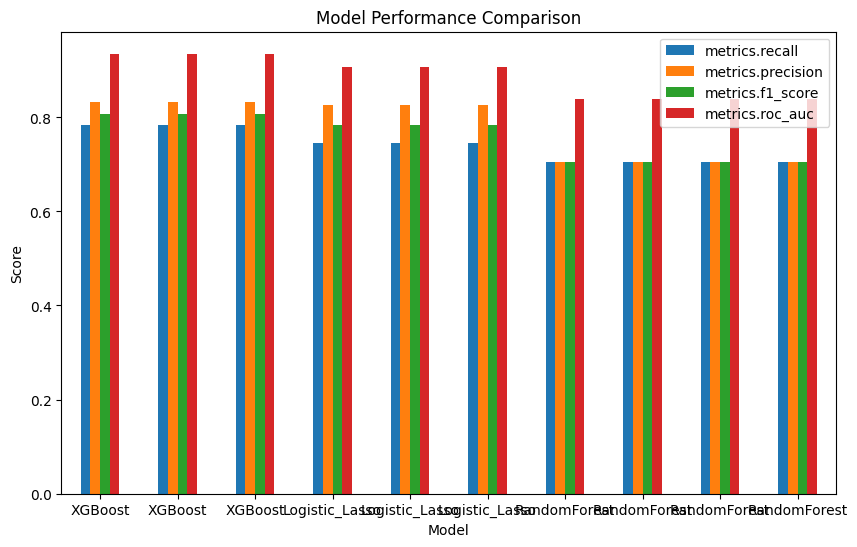

In [38]:
metrics = ["metrics.recall", "metrics.precision", "metrics.f1_score", "metrics.roc_auc"]

df_summary.plot(
    x="Model", y=metrics, kind="bar",
    figsize=(10,6), title="Model Performance Comparison"
)
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.show()

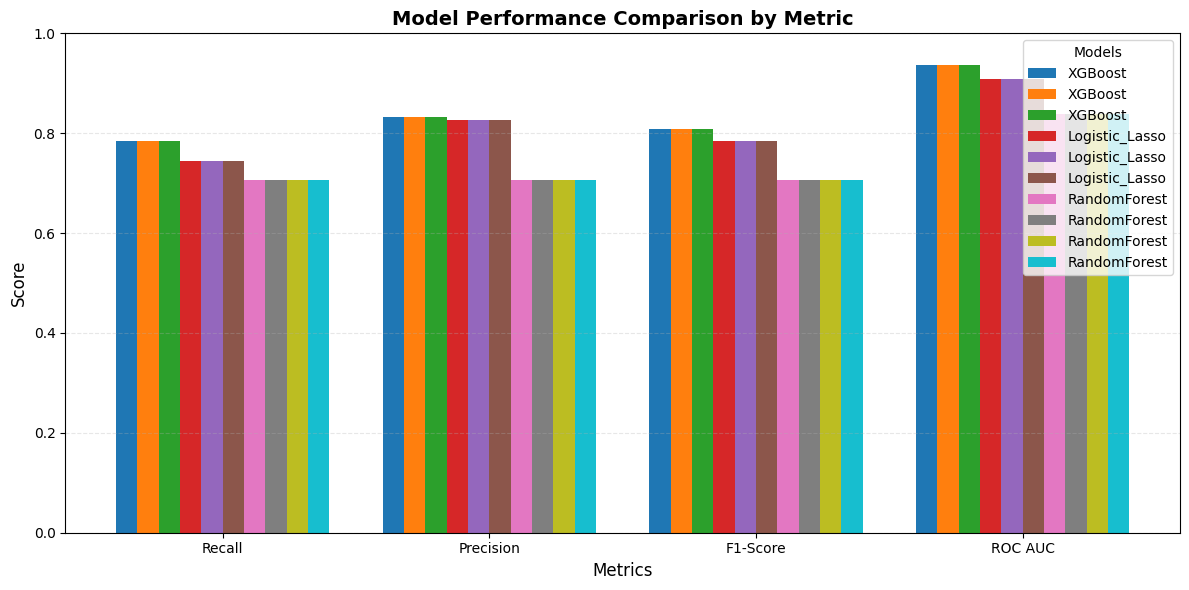

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Metrics to compare
metrics = ["metrics.recall", "metrics.precision", "metrics.f1_score", "metrics.roc_auc"]

# Prepare data for grouped bar chart
models = df_summary["Model"].values
metric_names = ["Recall", "Precision", "F1-Score", "ROC AUC"]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of bars and positions
x = np.arange(len(metrics))
width = 0.8 / len(models)  # Width of each bar

# Plot bars for each model
for i, model in enumerate(models):
    values = [df_summary.loc[df_summary["Model"] == model, metric].values[0] 
              for metric in metrics]
    offset = width * i - (width * len(models) / 2) + width / 2
    ax.bar(x + offset, values, width, label=model)

# Customize the plot
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Model Performance Comparison by Metric", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(title="Models")
ax.set_ylim(0, 1.0)  # Assuming metrics are between 0 and 1
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [40]:
best_run = df_summary.iloc[0]
print("Best Model:", best_run["Model"])
print("Recall:", best_run["metrics.recall"])
print("ROC-AUC:", best_run["metrics.roc_auc"])


Best Model: XGBoost
Recall: 0.7843137254901961
ROC-AUC: 0.93561603745976


In [41]:
run_id = best_run["run_id"]
loaded_model = mlflow.sklearn.load_model(f"runs:/{run_id}/{best_run['Model']}")


In [42]:
pred = loaded_model.predict(X_test)
